In [22]:
from pydub import AudioSegment
from pydub import effects
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import math
import matplotlib.mlab as mlab
import random
%matplotlib inline

#read in 15 different music clips from a given song of 3 seconds each
random_starts = np.random.randint(120000, size=15)

random_clips = [AudioSegment.from_file("../music/cellophane.mp3", format="mp3")[clip+1000:clip+4000] for clip in random_starts]

In [23]:
#helper function to convert an array to a sound clip for testing
def spawn_clip(sound, array):
    return sound._spawn(array)

In [24]:
array = random_clips[0]

new_sound = spawn_clip(random_clips[0], random_clips[0].get_array_of_samples())
new_sound

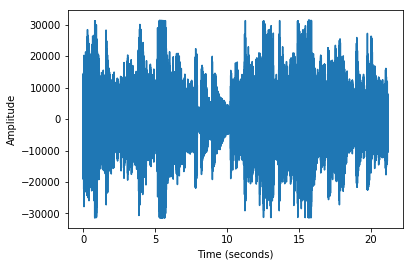

In [55]:
clip = sum(random_clips)[:24000]
arr = clip.get_array_of_samples()
plt.plot([i/100000 for i in range(len(arr))], arr)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.savefig("../figures/original_wf.png")
plt.show()

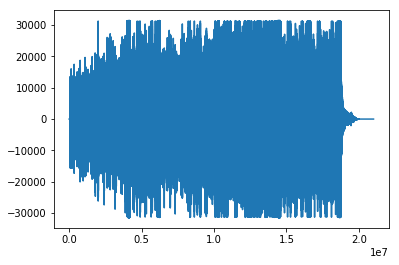

21014796

In [28]:
song = AudioSegment.from_file("../music/cellophane.mp3", format="mp3")[:20000000]
arr = song.get_array_of_samples()
plt.plot(arr)
plt.show()
len(arr)

Assuming, the notes of the music are distributed normally, by observation we see that the mean of this distribution is zero, but the variance needs to be predicted. Using MLE, we can predict the variance of the music notes and use it in our acceptance function to make sure the music we produce is more likely to come from a similar normal distribution


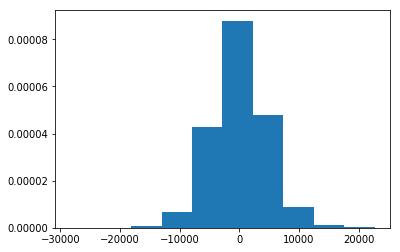

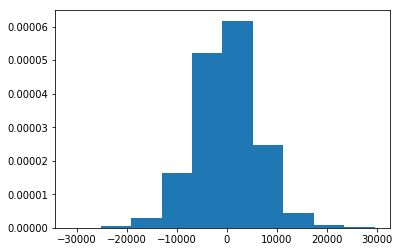

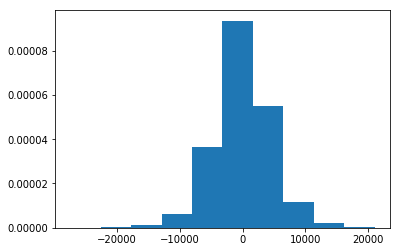

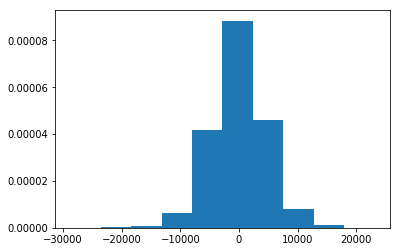

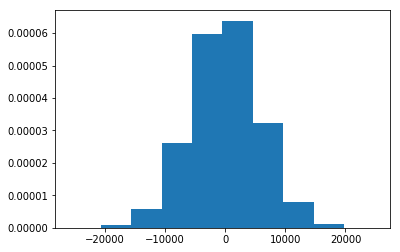

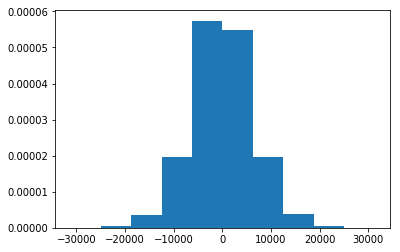

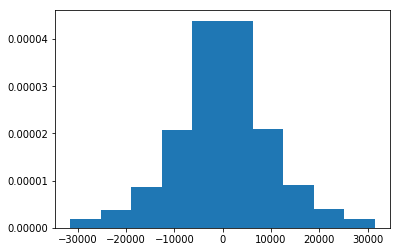

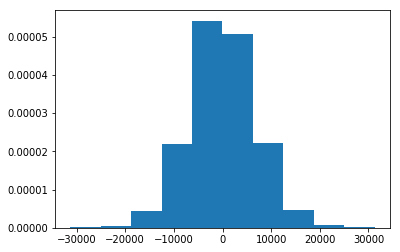

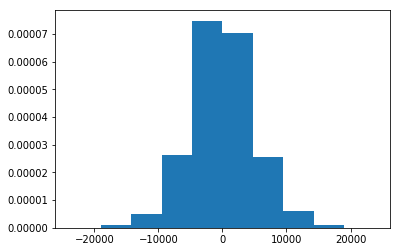

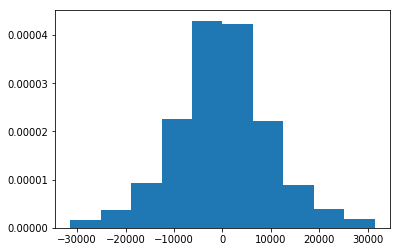

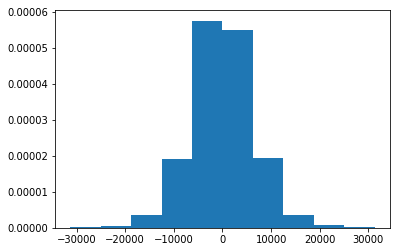

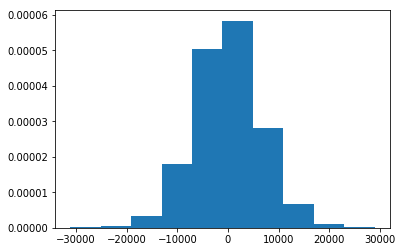

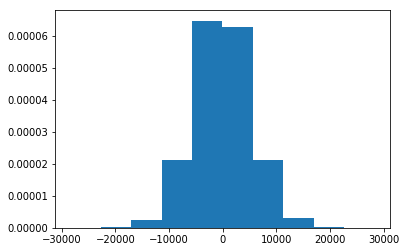

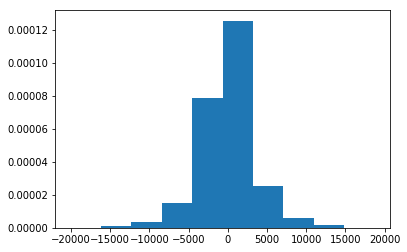

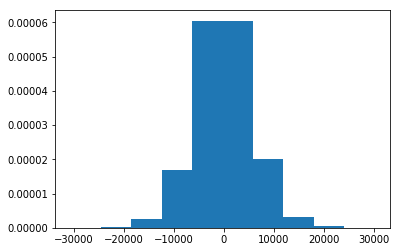

Predicted Variance: 39947250.926934235


In [4]:
#Estimate empirical variance from musical clips
stdArray = []

def mle(arr):
    return (1/len(arr))*sum([pow(x,2) for x in arr])

for clip in random_clips:
    arr = clip.get_array_of_samples()
    stdArray.append(mle(arr))
    plt.hist(arr, normed=True) 
    plt.show()
    
averageVar = sum(stdArray)/len(stdArray)
print("Predicted Variance:", averageVar)

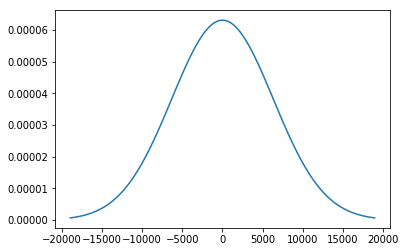

In [6]:
#prior normal distribution to score MCMC samples
sigma = averageStd
mu = 0
variance = averageVar
averageStd = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

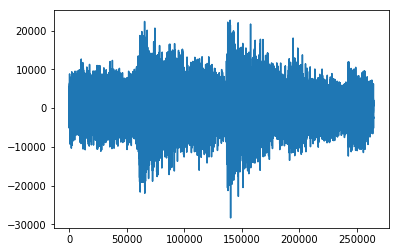

Intervals: [7106, 10497]


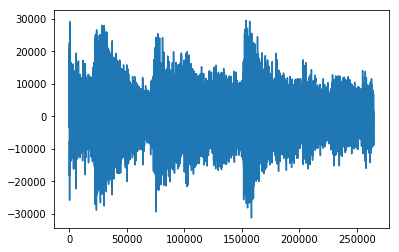

Intervals: [5988, 6155]


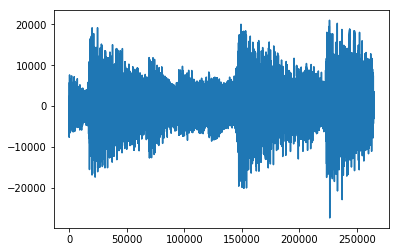

Intervals: [1176, 9189]


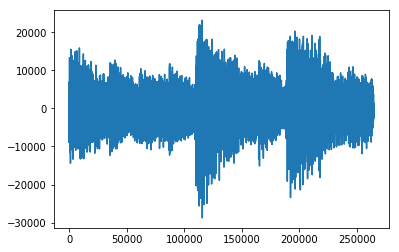

Intervals: [2169, 5456]


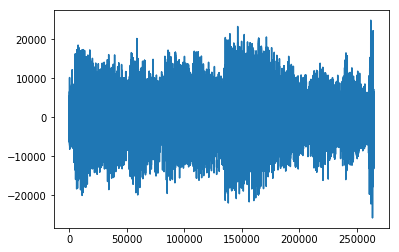

Intervals: [6515, 8331]


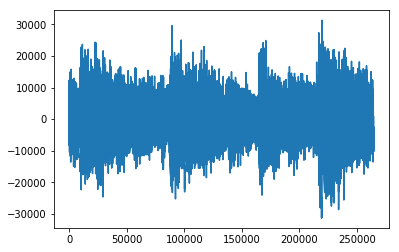

Intervals: [9736, 10504]


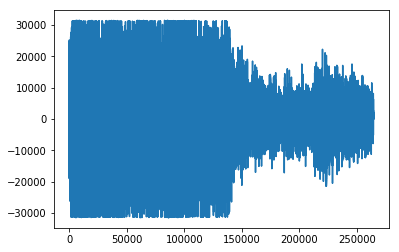

Intervals: [8855, 9391]


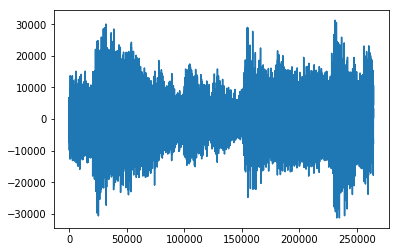

Intervals: [4723, 10699]


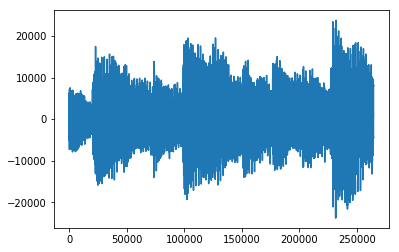

Intervals: [2908, 4595]


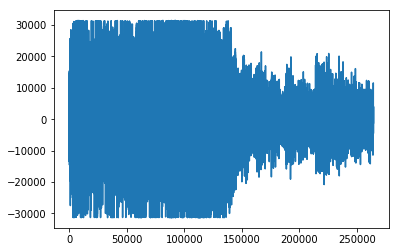

Intervals: [7037, 10687]


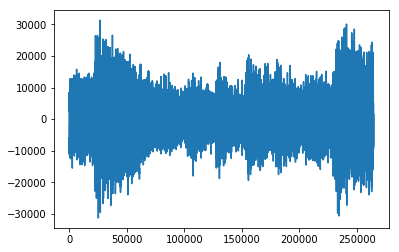

Intervals: [2484, 3101]


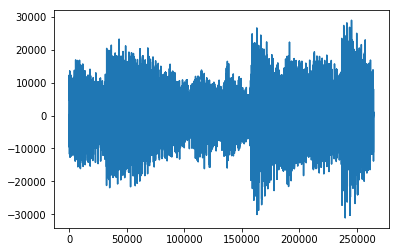

Intervals: [5336, 9379]


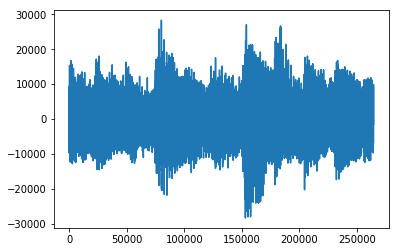

Intervals: [1472, 2595]


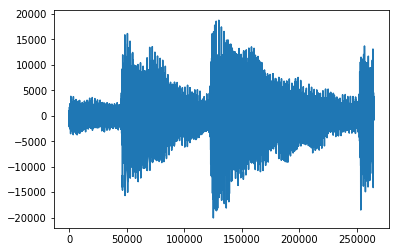

Intervals: [1323, 3585]


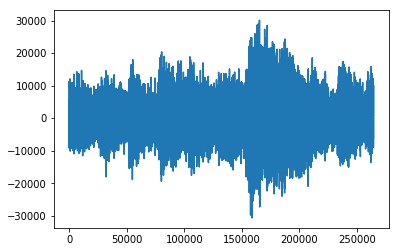

Intervals: [3999, 4000]


In [8]:
#Method 1 for creating music note groupings - try and find sudden changes in notes to capture each note

note_dictionary1 = {}
i = 0
for clip in random_clips:
    arr = clip.get_array_of_samples()
    plt.plot(arr)
    plt.show()

    test_array = clip.get_array_of_samples()
    diff_array = [abs(abs(test_array[i+1]) - abs(test_array[i])) for i in range(len(test_array) - 1)]
    #print(np.array(diff_array).argsort()[::-1])
    
    storedVals = []
    divPoints = []

    for x in np.array(diff_array).argsort()[::-1]:
        if str(x)[0] not in storedVals and x > 1000 and x < 12000:
            storedVals.append(str(x)[0])
            divPoints.append(x)
    shortList = divPoints[:2]
    shortList.sort()
    print("Intervals:", shortList)

    
    note_dictionary1[str(i)] = test_array[0:shortList[0]]
    note_dictionary1[str(i+1)] = test_array[shortList[0]:shortList[1]]
    note_dictionary1[str(i +2)] = test_array[shortList[1]:]
    i += 3

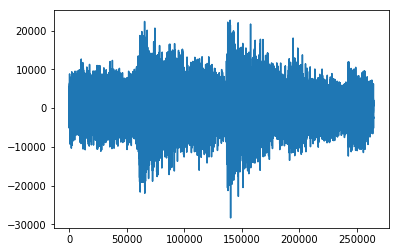

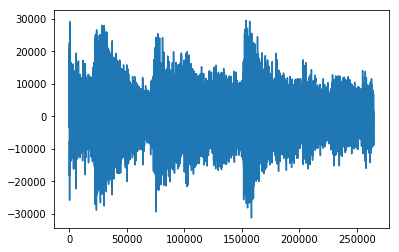

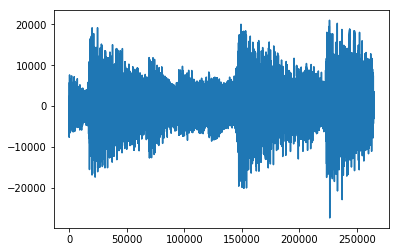

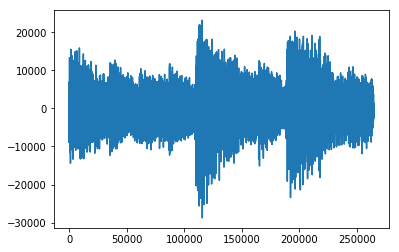

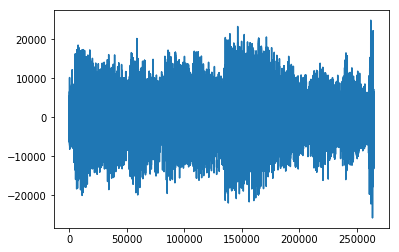

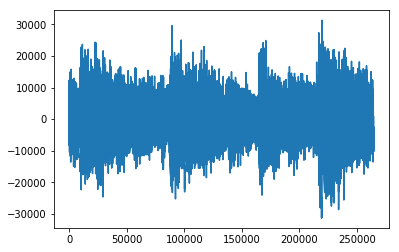

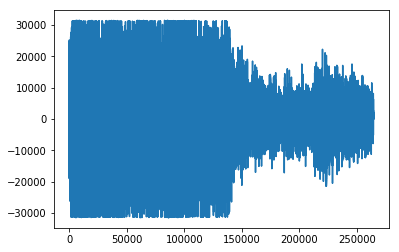

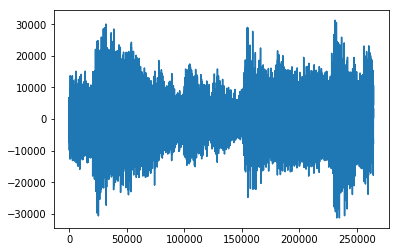

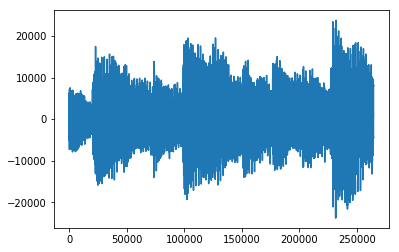

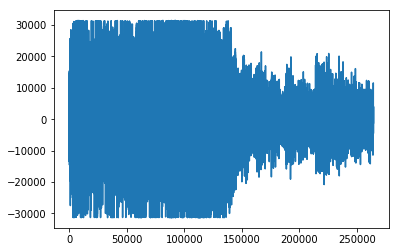

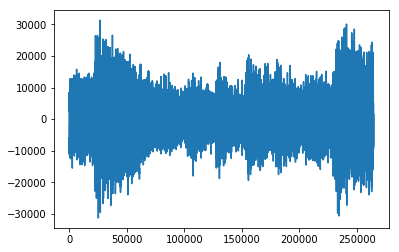

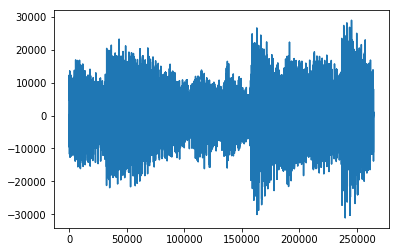

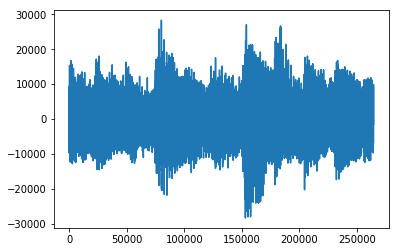

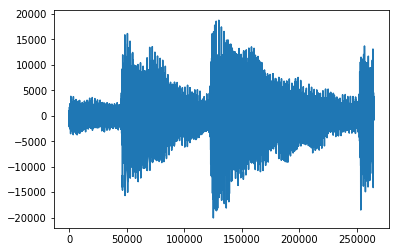

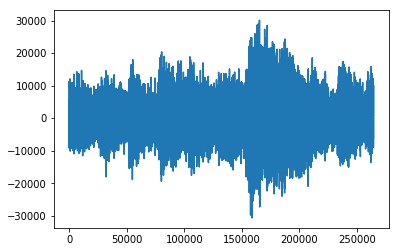

In [9]:
#Method 2 for creating music notes by splitting 3 second clip into equal length clips
note_dictionary2 = {}
i = 0
for clip in random_clips:
    arr = clip.get_array_of_samples()
    arrayLen = int(len(arr)/3)
    plt.plot(arr)
    plt.show()

    test_array = clip.get_array_of_samples()
    
    note_dictionary2[str(i)] = test_array[0:arrayLen]
    note_dictionary2[str(i+1)] = test_array[arrayLen:arrayLen*2]
    note_dictionary2[str(i +2)] = test_array[arrayLen*2:arrayLen*3]
    i += 3

In [10]:
def metropolis_hastings(proposal_func, init_func, acceptance_score, num_iters, step=30):
    """
    Runs the metropolis-hastings algorithm for
    num_iters iterations, using proposal_func
    to generate samples and scorer to assign
    probability scores to samples.
      
    proposal_func -- function that proposes
        candidate state; takes in current state as
        argument and returns candidate state
    init_func -- function that proposes starting
        state; takes no arguments and returns a
        sample state
    acceptance_score -- function that calculates the acceptance
        probability; takes in two state samples
        (candidate first, then sample) and returns
        acceptance probability
    
    Returns a sequence of every step-th sample. You 
    should only sample on upon acceptance of a new
    proposal. Do not keep sampling the current state.
    
    Note the total number of samples will NOT be
    equal to num_iters. num_iters is the total number
    of proposals we generate.
    """
    samples = []
    sample = init_func()
    for i in range(num_iters):
        candidate = proposal_func(sample)
        acceptance_ratio = min(1, acceptance_score(candidate,sample))
        if np.random.uniform() < acceptance_ratio:
            sample = candidate
            samples.append(sample)
    return samples[::step]

In [11]:
def normal_scorer(arr):
    score = 1
    random.shuffle(arr)
    for i in arr[0:1000]:
        score *= scipy.stats.norm(0,averageStd).pdf(i)
    return score

def starting_state():
    return np.random.randint(0,45,25)

def sample_candidate(sample):
    num_permute = 4 #hyperparameter
    sample = list(sample)
    for _ in range(num_permute):
        sample[np.random.randint(0,25)] = np.random.randint(0,45)
    return sample
    

def make_acceptance_scorer(transition_matrix):
    def scorer(candidate, sample):
        nonlocal transition_matrix
        
        #calculate sample/candidate score using transition probabilities between timeseries values
        transitionScore = 1
        for i in range(len(candidate) - 1):
            if transition_matrix[candidate[i]][candidate[i + 1]] != 0:
                transitionScore *= transition_matrix[candidate[i]][candidate[i + 1]]/transition_matrix[sample[i]][sample[i + 1]]
        
        #calculate sample/candidate score using prior normal distribution
        cand_music = []
        samp_music = []
        for note in candidate:
            cand_music += note_dictionary2[str(note)]
            
        for note in sample:
            samp_music += note_dictionary2[str(note)]
            
        normalScore = 1
        for _ in range(3): #sample 3 different sets of 1000 timeseries values
            i = np.random.randint(0,220500*12)
            normalScore *= normal_scorer(cand_music[i:i+1000])/normal_scorer(samp_music[i:i+1000])
            
        return  transitionScore * normalScore
    
    return scorer

3.13112356921e-08


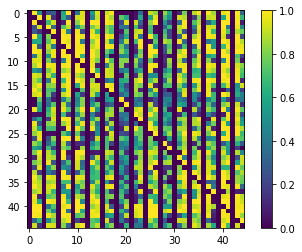

In [14]:
def generate(n, note_dict):
    shape = (n, n)
    mat = np.zeros(shape)
    
    arr = []
    
    for i in range(n-1):
        for j in range(n):
            if not(i % 3 == 2 or j == i+1):
                sim = similarity(note_dict[str(j)], note_dict[str(i)])
                arr.append(sim)
                mat[j][i+1] = sim 
    
    for i in range(n):
        if i % 3 != 2:
            mat[i][i+1] = 1
    
    max_small = max(arr)
    print(max_small)
    
    for i in range(n):
        for j in range(n):
            if mat[i][j] < 1:
                mat[i][j] /= max_small
                mat[i][j] = abs(mat[i][j])
                mat[i][j] = normalize(mat[i][j])
    
    return mat

def similarity(arr1, arr2):
    l1 = len(arr1)
    l2 = len(arr2)
    
    if l1 < l2:
        arr1.extend([0 for _ in range(l2-l1)])
    elif l1 > l2:
        arr2.extend([0 for _ in range(l1-l2)])

    dot = np.dot(arr1, arr2)
    normalization = np.linalg.norm(arr1) * np.linalg.norm(arr2)
    return dot / normalization

#0 to 1 -> push closer to 1
def normalize(x):
    return 2.0 / (1 + np.exp(-13 * x)) - 1
mat = generate(len(note_dictionary1), note_dictionary2)
plt.imshow(mat)
plt.colorbar()
plt.savefig("../figures/cellophane_mat.png")

Task List

probability of 1 for given data indexes above that we know are right after each other but then have to construct a decreasing function with respect to increasing L2 distance for all indexes to every other index and its known next data value 

For example, say we know that index 2 follows index 1 with probability 1 from the data, then we would take the index i for all i, measure the distance from index 1's vector to that of index i's vector and based on how far these vectors are, assign a probability to the transition from index i to index 2. The larger the distance from index 1, the smaller the probability of that transition should be

1. Split up 3 second music signals into effective groupings based on amplitude changes
2. Create dictionary mapping between our grouping index and array of music signal values of grouping
3. Further the L2 norm of grouping signal value array is from another array, it will have a smaller probability value of transitioning to the next array that the other array goes to. The other array has a probability of 1 of transitioning to the next music grouping 
4. In the end we do MCMC with just the integers representing the music groupings 
5. Add normal distribution (parameters found through MLE) to add to the acceptance function to make sure all values of music array being created is still normal - might be implied since we are doing MCMC over index integers

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


[[28, 17, 29, 5, 12, 43, 33, 37, 6, 42, 14, 22, 5, 27, 6, 3, 0, 5, 8, 28, 39, 11, 13, 19, 3]]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


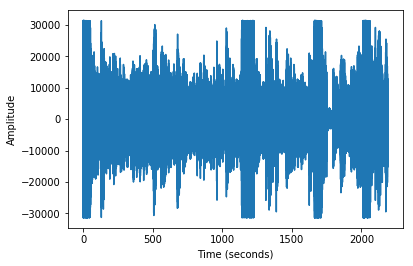

In [38]:
import array

def mostFrequent():
    #create function to see what sample from the MCMC occurs most frequently
    pass

scorer = make_acceptance_scorer(mat)
samples = metropolis_hastings(sample_candidate, starting_state, scorer, 10)

print(samples)
finalArray = samples[-1]

finalMusic = []

for note in finalArray:
    finalMusic += note_dictionary2[str(note)] 

b = [x for x in finalMusic if abs(x) > 50]
print(b)
plt.plot([i/1000 for i in range(len(b))], b)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()
#plt.savefig("../figures/generated_wf.png")
spawn_clip(new_sound, array.array('h', b))


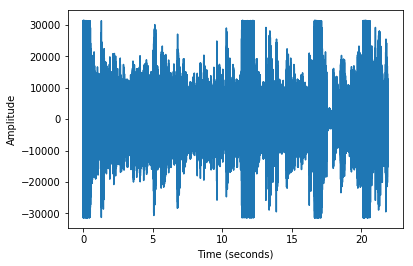

In [54]:
plt.plot([i/100000 for i in range(len(b))], b)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.savefig("../figures/generated_wf.png")
plt.show()

In [42]:
good_music = spawn_clip(new_sound, array.array('h', b))
good_music.export("../out/cellophane_generated.mp3")

<_io.BufferedRandom name='../out/cellophane_generated.mp3'>

<class 'array.array'>


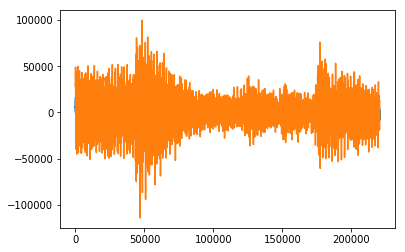

In [109]:
#Attempt to do a running average of music signal

arr = new_sound.get_array_of_samples()
averageVals = []

for i in range(0,len(arr)-50,50):
    sumTotal = np.sum(arr[i:i + 50])
    averageVals += [sumTotal/50] * 50

averageVals = [v*4 for v in averageVals]
plt.plot(arr)
print(type(arr))
plt.plot(averageVals)
spawn_clip(new_sound, arr)
spawn_clip(new_sound, averageVals)